# The Nature Conservancy Fisheries Monitoring

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/test_stg2.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: test_stg2/image_07154.jpg  
  inflating: test_stg2/image_07155.jpg  
  inflating: test_stg2/image_07156.jpg  
  inflating: test_stg2/image_07157.jpg  
  inflating: test_stg2/image_07158.jpg  
  inflating: test_stg2/image_07159.jpg  
  inflating: test_stg2/image_07160.jpg  
  inflating: test_stg2/image_07161.jpg  
  inflating: test_stg2/image_07162.jpg  
  inflating: test_stg2/image_07163.jpg  
  inflating: test_stg2/image_07164.jpg  
  inflating: test_stg2/image_07165.jpg  
  inflating: test_stg2/image_07166.jpg  
  inflating: test_stg2/image_07167.jpg  
  inflating: test_stg2/image_07168.jpg  
  inflating: test_stg2/image_07169.jpg  
  inflating: test_stg2/image_07170.jpg  
  inflating: test_stg2/image_07171.jpg  
  inflating: test_stg2/image_07172.jpg  
  inflating: test_stg2/image_07173.jpg  
  inflating: test_stg2/image_07174.jpg  
  inflating: test_stg2/image_07175.jpg  
  inflating: test_stg2/image_0

https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring

In [3]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

print(tf.__version__)

2.17.0


# Загружаем разметку

In [4]:
import os
import json
from glob import glob

TRAIN_PREFIX = 'drive/MyDrive/data/fish/train'

def load_annotations():
    boxes = dict()
    for path in glob('drive/MyDrive/data/fish/boxes/*.json'):
        label = os.path.basename(path).split('_', 1)[0]
        with open(path) as src:
            for annotation in json.load(src):
                basename = os.path.basename(annotation['filename'])
                annotation['filename'] = os.path.join(
                    TRAIN_PREFIX, label.upper(), basename)
                for rect in annotation['annotations']:
                    rect['x'] += rect['width'] / 2
                    rect['y'] += rect['height'] / 2
                if os.path.isfile(annotation['filename']):
                    boxes.setdefault(label, []).append(annotation)
    return boxes

def draw_boxes(annotation, rectangles=None, image_size=None):

    def _draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for rect in rectangles:
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2,
                                color=color, thickness=4)
        return img

    scale_x, scale_y = 1., 1.

    img = cv2.imread(annotation['filename'], cv2.IMREAD_COLOR)[...,::-1]
    if image_size is not None:
        scale_x = 1. * image_size[0] / img.shape[1]
        scale_y = 1. * image_size[1] / img.shape[0]
        img = cv2.resize(img, image_size)

    img = _draw(img, annotation.get('annotations', []), scale_x, scale_y)

    if rectangles is not None:
        img = _draw(img, rectangles, 1., 1., (255, 0, 0))

    return img

### Визуализируем разметку

In [5]:
boxes = load_annotations()  # загружаем разметку детекций

In [ ]:
pd.DataFrame(
    [(k, len(v)) for k, v in boxes.items()],
    columns=['class', 'count'])

,class,count
0,dol,2
1,alb,27
2,bet,5
3,shark,4
4,lag,2
5,yft,12


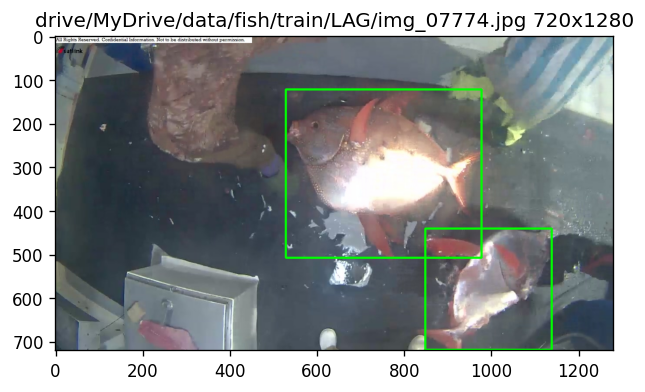

In [ ]:
# from matplotlib import pyplot as plt


# annotation = boxes['lag'][0]
# img = draw_boxes(annotation)

# plt.figure(figsize=(6, 6), dpi=120)
# plt.imshow(img)
# plt.title('{} {}x{}'.format(
#     annotation['filename'], img.shape[0], img.shape[1]));

### Распределение размеров разметки

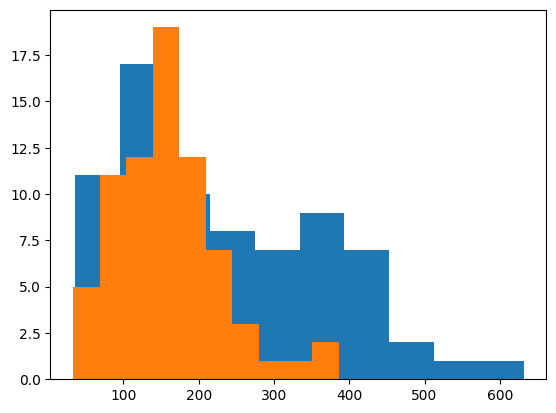

In [ ]:
# annotations = sum([box['annotations']
#                    for box in sum(boxes.values(), [])], [])

# widths = [rect['width'] for rect in annotations]
# heights = [rect['height'] for rect in annotations]

# plt.hist(widths)
# plt.hist(heights);

# Экстрактор признаков

In [6]:
from tensorflow.keras.applications import vgg16

IMG_HEIGHT = 750
IMG_WIDTH = 1200

features = vgg16.VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# дообучаем последние 5 слоев
for layer in features.layers[:-5]:
    layer.trainable = False

feature_tensor = features.layers[-1].output
print(feature_tensor.shape)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
(None, 23, 37, 512)


# Сетка якорей (anchor grid)

In [7]:
FEATURE_SHAPE = (feature_tensor.shape[1],
                 feature_tensor.shape[2])

GRID_STEP_H = IMG_HEIGHT / FEATURE_SHAPE[0]
GRID_STEP_W = IMG_WIDTH / FEATURE_SHAPE[1]

ANCHOR_WIDTH = 150.
ANCHOR_HEIGHT = 150.

# сетка якорей, размер определяется соотношением
# размера входного изображения и размером тензора признаков
ANCHOR_CENTERS = np.mgrid[GRID_STEP_H/2:IMG_HEIGHT:GRID_STEP_H,
                          GRID_STEP_W/2:IMG_WIDTH:GRID_STEP_W]

In [8]:
def iou(rect, x_scale, y_scale, anchor_x, anchor_y,
        anchor_w=ANCHOR_WIDTH, anchor_h=ANCHOR_HEIGHT):

    rect_x1 = (rect['x'] - rect['width'] / 2) * x_scale
    rect_x2 = (rect['x'] + rect['width'] / 2) * x_scale

    rect_y1 = (rect['y'] - rect['height'] / 2) * y_scale
    rect_y2 = (rect['y'] + rect['height'] / 2) * y_scale

    anch_x1, anch_x2 = anchor_x - anchor_w / 2, anchor_x + anchor_w / 2
    anch_y1, anch_y2 = anchor_y - anchor_h / 2, anchor_y + anchor_h / 2

    dx = (min(rect_x2, anch_x2) - max(rect_x1, anch_x1))
    dy = (min(rect_y2, anch_y2) - max(rect_y1, anch_y1))

    intersection = dx * dy if (dx > 0 and dy > 0) else 0.

    anch_square = (anch_x2 - anch_x1) * (anch_y2 - anch_y1)
    rect_square = (rect_x2 - rect_x1) * (rect_y2 - rect_y1)
    union = anch_square + rect_square - intersection

    return intersection / union

def encode_anchors(annotation, img_shape, iou_thr=0.5):
    encoded = np.zeros(shape=(FEATURE_SHAPE[0],
                              FEATURE_SHAPE[1], 5), dtype=np.float32)
    x_scale = 1. * IMG_WIDTH / img_shape[1]
    y_scale = 1. * IMG_HEIGHT / img_shape[0]
    for rect in annotation['annotations']:
        scores = []
        for row in range(FEATURE_SHAPE[0]):
            for col in range(FEATURE_SHAPE[1]):
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                score = iou(rect, x_scale, y_scale, anchor_x, anchor_y)
                scores.append((score, anchor_x, anchor_y, row, col))

        scores = sorted(scores, reverse=True)
        if scores[0][0] < iou_thr:
            scores = [scores[0]]  # default anchor
        else:
            scores = [e for e in scores if e[0] > iou_thr]

        for score, anchor_x, anchor_y, row, col in scores:
            dx = (anchor_x - rect['x'] * x_scale) / ANCHOR_WIDTH
            dy = (anchor_y - rect['y'] * y_scale) / ANCHOR_HEIGHT
            dw = (ANCHOR_WIDTH - rect['width'] * x_scale) / ANCHOR_WIDTH
            dh = (ANCHOR_HEIGHT - rect['height'] * y_scale) / ANCHOR_HEIGHT
            # one-hot_label =
            encoded[row, col] = [1., dx, dy, dw, dh]

    return encoded

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def decode_prediction(prediction, conf_thr=0.1):
    rectangles = []
    for row in range(FEATURE_SHAPE[0]):
        for col in range(FEATURE_SHAPE[1]):
            logit, dx, dy, dw, dh = prediction[row, col]
            conf = _sigmoid(logit)
            if conf > conf_thr:
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                rectangles.append({'x': anchor_x - dx * ANCHOR_WIDTH,
                                   'y': anchor_y - dy * ANCHOR_HEIGHT,
                                   'width': ANCHOR_WIDTH - dw * ANCHOR_WIDTH,
                                   'height': ANCHOR_HEIGHT - dh * ANCHOR_HEIGHT,
                                   'conf': conf})
    return rectangles

def non_max_suppression(rectangles, max_output_size, iou_threshold=0.5):
    if not rectangles:
        return rectangles

    boxes = [[r['y'],
              r['x'],
              r['y'] + r['height'],
              r['x'] + r['width']] for r in rectangles]
    scores = [r['conf'] for r in rectangles]
    indices = tf.image.non_max_suppression(np.array(boxes),
                                           np.array(scores),
                                           max_output_size,
                                           iou_threshold)

    return [rectangles[i] for i in indices]

### Валидация энкодинга/декодинга якорей

In [ ]:
annotation = boxes['lag'][0]

encoded = encode_anchors(annotation,
                         img_shape=(IMG_HEIGHT, IMG_WIDTH),
                         iou_thr=0.5)

decoded = decode_prediction(encoded, conf_thr=0.7)
decoded = sorted(decoded, key = lambda e: -e['conf'])

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(draw_boxes(annotation, decoded))
plt.title('{} {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));

NameError: name 'plt' is not defined

## Функция потерь

In [9]:
import keras

In [20]:
K = tf.keras.backend

@keras.saving.register_keras_serializable()
def confidence_loss(y_true, y_pred):
    conf_loss = K.binary_crossentropy(y_true[..., 0],
                                      y_pred[..., 0],
                                      from_logits=True)
    return conf_loss

@keras.saving.register_keras_serializable()
def smooth_l1(y_true, y_pred):
    abs_loss = K.abs(y_true[..., 1:5] - y_pred[..., 1:5]) # FEATURE FIX LIMITED X,Y,H,W COORDS DIMENSIONS [..., 1:] => [..., 1:5]
    square_loss = 0.5 * K.square(y_true[..., 1:5] - y_pred[..., 1:5]) # FEATURE FIX LIMITED X,Y,H,W COORDS DIMENSIONS [..., 1:] => [..., 1:5]
    mask = K.cast(K.greater(abs_loss, 1.), 'float32')
    total_loss = (abs_loss - 0.5) * mask + 0.5 * square_loss * (1. - mask)
    return K.sum(total_loss, axis=-1)

# FEATURE FIX CLASSIFICATION LOSS
@keras.saving.register_keras_serializable()
def classification_loss(y_true, y_pred):
    loss = K.categorical_crossentropy(y_true[..., 5:13], # 5:13 - dimensions of 8 classes
                                      y_pred[..., 5:13], # 5:13 - dimensions of 8 classes
                                      from_logits=True)

    # EXPLANATION just sum up loss vals over batches
    # loss = loss
    return loss
# FEATURE FIX

@keras.saving.register_keras_serializable()
def total_loss(y_true, y_pred, neg_pos_ratio=3):
    batch_size = K.shape(y_true)[0]

    # TODO: добавьте функцию потерь для классификации детекции

    y_true = K.reshape(y_true, (batch_size, -1, 13)) #FEATURE FIX 5 => 13
    y_pred = K.reshape(y_pred, (batch_size, -1, 13)) #FEATURE FIX 5 => 13

    # confidence loss
    conf_loss = confidence_loss(y_true, y_pred)

    # smooth l1 loss
    loc_loss = smooth_l1(y_true, y_pred)

    ## FEATURE ADD classification loss
    class_loss = classification_loss(y_true, y_pred)

    # # positive examples loss
    # pos_conf_loss = K.sum(conf_loss * y_true[..., 0], axis=-1)
    # pos_loc_loss = K.sum(loc_loss * K.sum(y_true[..., 1:5], axis=-1), axis=-1)
    # argmax = tf.keras.ops.argmax(y_true[..., 5:13], axis=-1)
    # classes = K.cast(argmax, 'float32')
    # pos_class_loss = K.sum(class_loss * classes, axis=-1)

    # # negative examples loss
    # anchors = K.shape(y_true)[1]
    # num_pos = K.sum(y_true[..., 0], axis=-1)
    # num_pos_avg = K.mean(num_pos)
    # num_neg = K.min([neg_pos_ratio * (num_pos_avg) + 1., K.cast(anchors, 'float32')])

    # # hard negative mining
    # neg_conf_loss, _ = tf.nn.top_k(conf_loss * (1. - y_true[..., 0]),
    #                                k=K.cast(num_neg, 'int32'))

    # neg_conf_loss = K.sum(neg_conf_loss, axis=-1)

    # # total conf loss
    # total_conf_loss = (neg_conf_loss + pos_conf_loss) / (num_neg + num_pos + 1e-32)
    # loc_loss = pos_loc_loss / (num_pos + 1e-32)
    # class_loss = pos_class_loss / (num_pos + 1e-32)

    return conf_loss + 0.5 * loc_loss + class_loss
    # total_conf_loss + 0.5 * loc_loss

## Загрузка данных

In [11]:
from random import shuffle

def load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    img = cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1]
    img_shape = img.shape
    img_resized = cv2.resize(img, target_size)
    return img_shape, vgg16.preprocess_input(img_resized.astype(np.float32))

# My code
def make_with_labels(anchors, box):
    codes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
    flabel = box['filename'].split('/')[-2]
    # JP Notebook: .split('\\')[1]
    lbls = list(map(lambda x: int(x==flabel), codes))

    with_labels = np.zeros((23,37,13))
    for i in range(anchors.shape[0]):
        for j in range(anchors.shape[1]):
            if sum(anchors[i,j]) > 0:
                with_labels[i,j] = np.append(anchors[i,j], lbls)
            else:
                with_labels[i,j] = np.append(anchors[i,j], np.zeros(8))
    return with_labels.astype('float32')
# My code

def data_generator(boxes, batch_size=32):
    boxes = sum(boxes.values(), [])
    while True:
        shuffle(boxes)
        for i in range(len(boxes)//batch_size):
            X, y = [], []
            for j in range(i*batch_size,(i+1)*batch_size):
                img_shape, img = load_img(boxes[j]['filename'])
                # TODO: добавьте one-hot encoding в разметку для классов
                # FEATURE FIX
                anchors = encode_anchors(boxes[j], img_shape)
                anchors_w_labels = make_with_labels(anchors, boxes[j])
                # FEATURE FIX
                y.append(anchors_w_labels)
                X.append(img)
            yield np.array(X), np.array(y)


## Добавляем выход детектора

In [ ]:
# def different_activations(input_):
#   conf = tf.keras.activations.sigmoid(input_[..., 0:1]) # sigmoid for confidence activation counting
#   regr = tf.keras.activations.linear(input_[..., 1:5]) # linear for regression of bbox
#   clas = tf.keras.activations.softmax(input_[..., 5:]) # softmax for multiclass classification

#   l_fin = tf.concat([conf, regr, clas], axis=-1)
#   return l_fin

In [ ]:
import keras

In [12]:
@keras.saving.register_keras_serializable()
class different_activations(tf.keras.layers.Layer):
    def __init__(self, trainable=True, **kwargs):
      super(different_activations, self).__init__(**kwargs)
      self.trainable = trainable
      self.conf = tf.keras.activations.sigmoid # sigmoid for confidence activation counting
      self.regr = tf.keras.activations.linear # linear for regression of bbox
      self.clas = tf.keras.activations.softmax # softmax for multiclass classification

    def call(self, x):
      conf = self.conf(x[..., 0:1]) # sigmoid for confidence activation counting
      regr = self.regr(x[..., 1:5]) # linear for regression of bbox
      clas = self.clas(x[..., 5:]) # softmax for multiclass classification

      l_fin = tf.concat([conf, regr, clas], axis=-1)
      return l_fin

    def get_config(self):
        base_config = super(different_activations, self).get_config()
        config = {
            "trainable": self.trainable
        }
        return {**base_config, **config}

    @classmethod
    def from_config(cls, config):
        # conf_config = config.pop("conf")
        # regr_config = config.pop("regr")
        # class_config = config.pop("clas")
        # conf = tf.keras.saving.deserialize_keras_object(conf_config)
        # regr = tf.keras.saving.deserialize_keras_object(regr_config)
        # clas = tf.keras.saving.deserialize_keras_object(class_config)
        return cls(**config)

In [13]:
output = tf.keras.layers.BatchNormalization()(feature_tensor)

# TODO: добавьте выходы для классификации детекции
output = tf.keras.layers.Conv2D(13, # add 8 more filters since we have 8 more classes
                                kernel_size=(1, 1), # FEATURE ADD different activations for different filters :D
                                kernel_regularizer='l2')(output)
activation = different_activations()(output)

model = tf.keras.models.Model(inputs=features.inputs, outputs=activation)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 750, 1200, 3)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 750, 1200, 64)       │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 750, 1200, 64)       │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 375, 600, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 375, 600, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 375, 600, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 187, 300, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 187, 300, 256)       │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 187, 300, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 187, 300, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 93, 150, 256)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 93, 150, 512)        │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 93, 150, 512)        │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 93, 150, 512)        │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 46, 75, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 46, 75, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 46, 75, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 46, 75, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 23, 37, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 23, 37, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 23, 37, 13)          │           6,6

 Total params: 14,723,405 (56.17 MB)

 Trainable params: 7,087,117 (27.04 MB)

 Non-trainable params: 7,636,288 (29.13 MB)

## Обучение

In [17]:
adam = tf.keras.optimizers.Adam(learning_rate=0.003)
model.compile(optimizer=adam,
              loss=classification_loss,
              metrics=[confidence_loss, classification_loss])

In [ ]:
# model = keras.models.load_model('model.keras')

In [18]:
batch_size = 8

gen = data_generator(boxes, batch_size=batch_size)
steps_per_epoch = int(sum(map(len, boxes.values()), 0) / batch_size)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'fishdetector_best.weights.h5',
    monitor='loss',
    verbose=5,
    save_best_only=True,
    save_weights_only=True,
    mode='auto',
    save_freq=10)

In [19]:
model.fit(gen,
          steps_per_epoch=steps_per_epoch,
          epochs=50,
          callbacks=[checkpoint],
          verbose=2)

# model.save_weights('fishdetector_last_epoch.weights.h5')
model.save('model.keras')

Epoch 1/50
6/6 - 9s - 2s/step - classification_loss: 0.0051 - confidence_loss: 0.6972 - loss: 0.6410
Epoch 2/50

Epoch 2: loss improved from inf to 0.53012, saving model to fishdetector_best.weights.h5
6/6 - 7s - 1s/step - classification_loss: 0.0057 - confidence_loss: 0.7106 - loss: 0.5114
Epoch 3/50
6/6 - 5s - 883ms/step - classification_loss: 0.0058 - confidence_loss: 0.7475 - loss: 0.4130
Epoch 4/50

Epoch 4: loss improved from 0.53012 to 0.35753, saving model to fishdetector_best.weights.h5
6/6 - 6s - 921ms/step - classification_loss: 0.0058 - confidence_loss: 0.8117 - loss: 0.3315
Epoch 5/50

Epoch 5: loss improved from 0.35753 to 0.26269, saving model to fishdetector_best.weights.h5
6/6 - 7s - 1s/step - classification_loss: 0.0056 - confidence_loss: 0.8831 - loss: 0.2627
Epoch 6/50
6/6 - 6s - 953ms/step - classification_loss: 0.0055 - confidence_loss: 0.9369 - loss: 0.2076
Epoch 7/50

Epoch 7: loss improved from 0.26269 to 0.17052, saving model to fishdetector_best.weights.h5
6/

## Результат работы детектора

In [ ]:
# model.load_weights('data/fish/fishdetector_weights.hdf5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


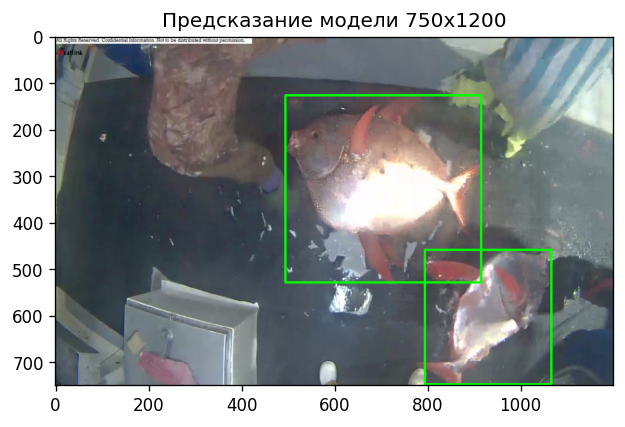

In [ ]:
annotation = boxes['lag'][0]

_, sample_img = load_img(annotation['filename'])
pred = model.predict(np.array([sample_img,]))

decoded = decode_prediction(pred[0][:,:,:5], conf_thr=0.001)
decoded = non_max_suppression(decoded,
                              max_output_size=5,
                              iou_threshold=0.0001)

plt.figure(figsize=(6, 6), dpi=120)
img = draw_boxes(annotation, decoded, (IMG_WIDTH, IMG_HEIGHT))
plt.imshow(img)
plt.title('Предсказание модели {}x{}'.format(*img.shape));

## Визуализируем предсказание на тесте

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


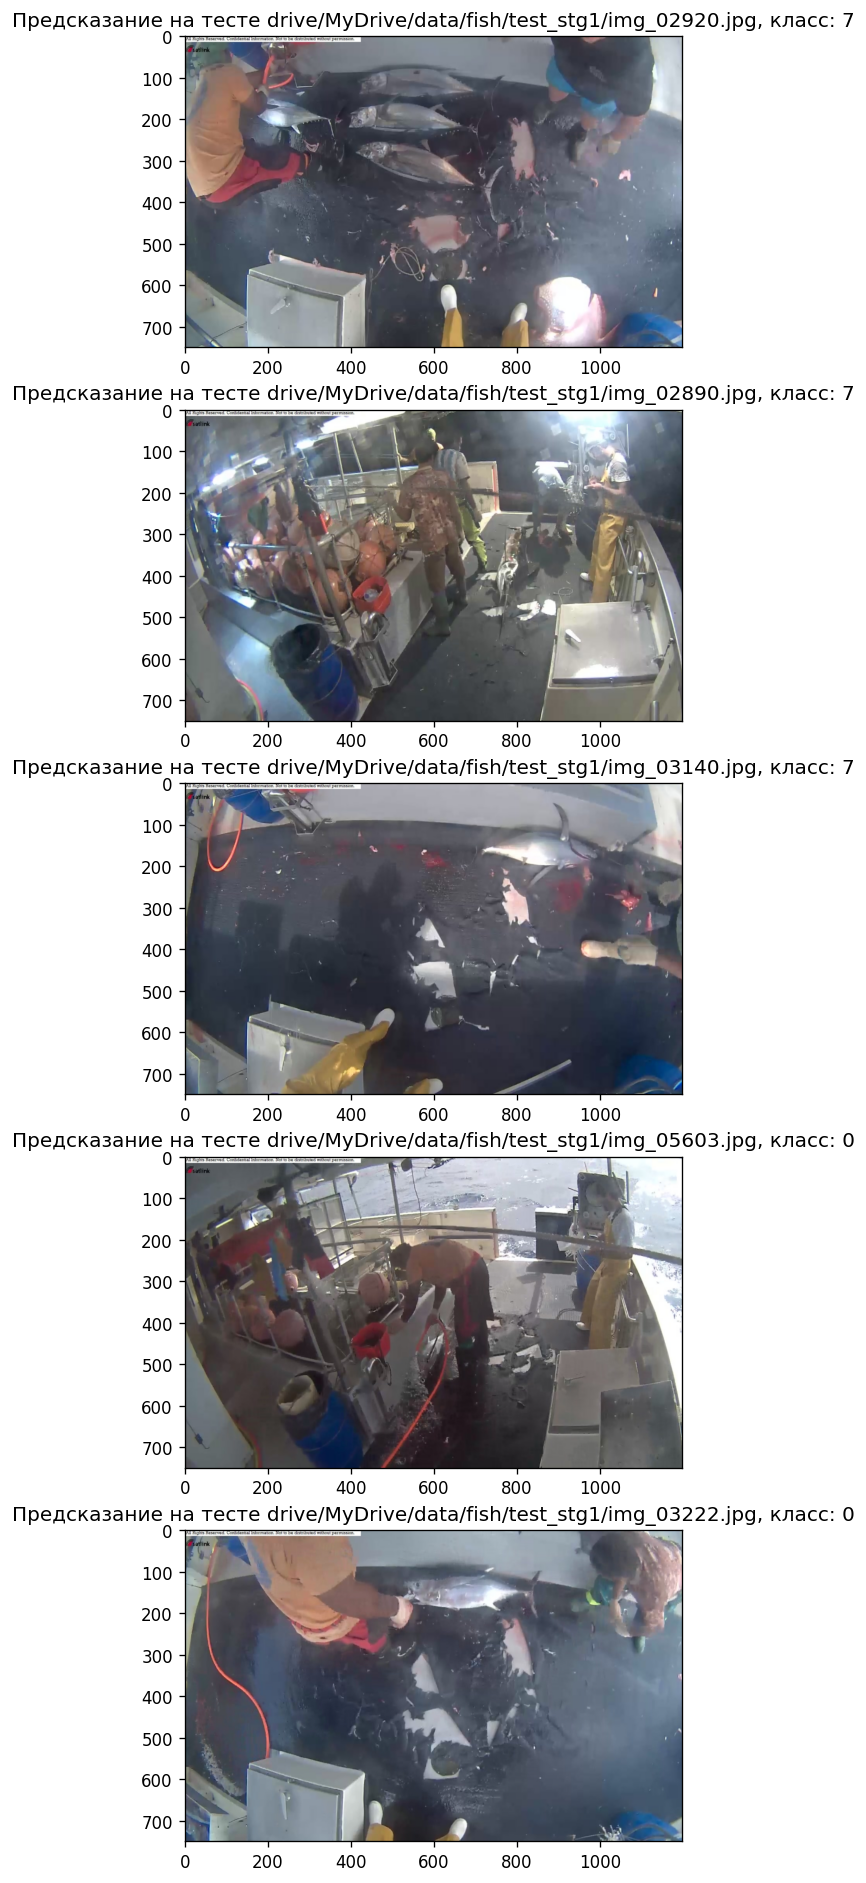

In [ ]:
test_images = glob('drive/MyDrive/data/fish/test_stg1/*.jpg')


plt.figure(figsize=(6, 4 * len(test_images)), dpi=120)

for i, filename in enumerate(test_images[-5:]):
    _, sample_img = load_img(filename)
    pred = model.predict(np.array([sample_img,]))

    decoded = decode_prediction(pred[0][:,:,:5], conf_thr=0.0)
    decoded = non_max_suppression(decoded,
                                  max_output_size=2,
                                  iou_threshold=0.1)

    pred_class = np.argmax(np.abs(tf.reduce_max(pred[..., 5:], axis=[0,1,2])))

    plt.subplot(len(test_images), 1, i + 1)
    img = draw_boxes({'filename': filename}, decoded, (IMG_WIDTH, IMG_HEIGHT))
    plt.imshow(img)
    plt.title('Предсказание на тесте {}, класс: {}'.format(filename, pred_class));

## Агрегация результатов

In [21]:
from tqdm import tqdm

def get_predictions(test_path=glob('test_stg2/*.jpg'), from_=0):
  for i, filename in tqdm(enumerate(test_path[from_:]), total = len(test_path[from_:])):
    _, sample_img = load_img(filename)
    class_pred = model.predict(np.array([sample_img,]), verbose=0)[..., 5:]
    prob_classes = list(np.abs(tf.reduce_mean(class_pred, axis=[0,1,2])))
    yield [filename.split('/')[-1]] + prob_classes

In [ ]:
# TODO: предскажите класс рыбы для фотографии из тестовой выборки
#
# Подготовьте файл с предсказаниями вероятностей для каждой фотографии:
# image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
# img_00001.jpg,1,0,0,0,0,...,0
# img_00002.jpg,0.3,0.1,0.6,0,...,0

In [26]:
headers = 'image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT'

with open('submission.txt', 'w') as file:
  file.write(f'{headers}\n')
  file.writelines(f'{",".join(str(i) for i in row)}\n' for row in get_predictions())

100%|██████████| 12153/12153 [43:46<00:00,  4.63it/s]
